<h1 style="font-size: 40px">Value at Risk with Standard Distributions</h1>

<h2 style="font-size:30px"><ins>THEORY</ins></h2> The Value at Risk(VaR) for a given asset/investment is a statistical measure of the risk of loss that an investor is exposed to. It estimates, as a percentage of the asset value, the potential losses an investor could incur over a given period of time, with a given degree of confidence. For example, one might say that the Value at Risk on a stock over the course of a month is 5% with a 68% confidence level. Loosely speaking, this means that there's a 68% chance that the stock will fall(at most) by 5%. Raising the confidence level leads to a higher VaR, whereas lowering it has the opposite effect. Value of Risk is an important metric for a financial institution's internal controls as well as external regulations.

<h2>Calculating VaR</h2>
One of the most common ways to calculate Value at Risk is to collect historical data on asset returns and fit it to a standard distribution. The parameters of the distribution can then help quantify the VaR, usually by means of a percentile score. The normal distribution is often chosen for this purpose, but it is known<a href="#ref1"><sup>[1]</sup></a>. that Student's t-distribution sometimes provides better estimates of risk, especially when the histogram of returns is fat-tailed. In such cases, the normal distribution fails to adequately capture potential losses at higher confidence levels, leading to an underestimation of risk. The figure below illustrates the situation using synthetic data.

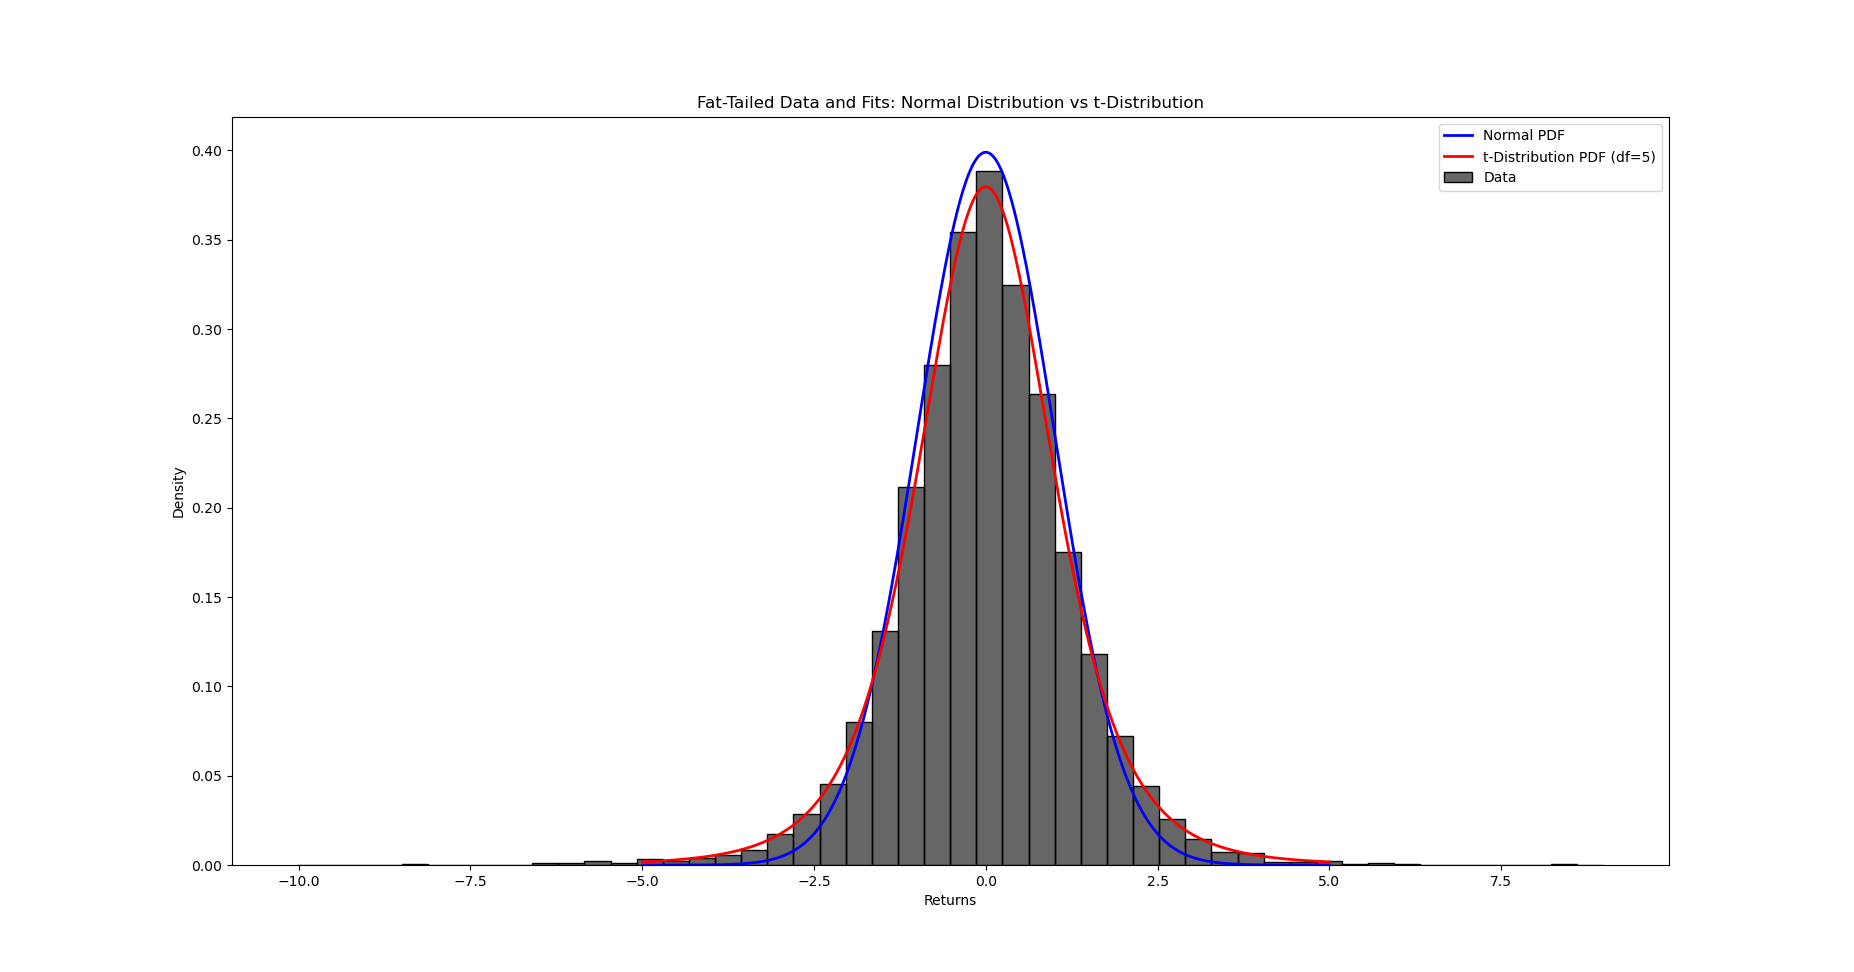

<h3>Normal Distribution</h3>
A random variable is said to be normally distributed if it has the following probability density:
$$
f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\left( \frac{x-\mu}{\sqrt{2} \sigma}\right)^2}
$$
As such, a normal distribution is completely determined by two parameters: its mean $\mu$ and its variance $\sigma$. Assuming that asset returns are normally distributed, the Value at Risk is given by the formula<a href="#ref1"><sup>[1]</sup></a>
$$
\begin{equation}
\text{VaR}_n = \mu - z_{\alpha} \sigma \tag{1}
\end{equation}
$$
where $\mu$ and $\sigma$ are the mean and standard deviation of the underlying data, respectively. The number $z_\alpha$ is the z-score(distance from the mean as a multiple of $\sigma$) at a confidence interval of $\alpha$(see fig. below):

$$
z_\alpha = \frac{x-\mu}{\sigma}
$$

Some authors use a different convention and write $\text{VaR}_n = \mu + z_{1-\alpha} \sigma$ instead, but both definitions are equivalent.

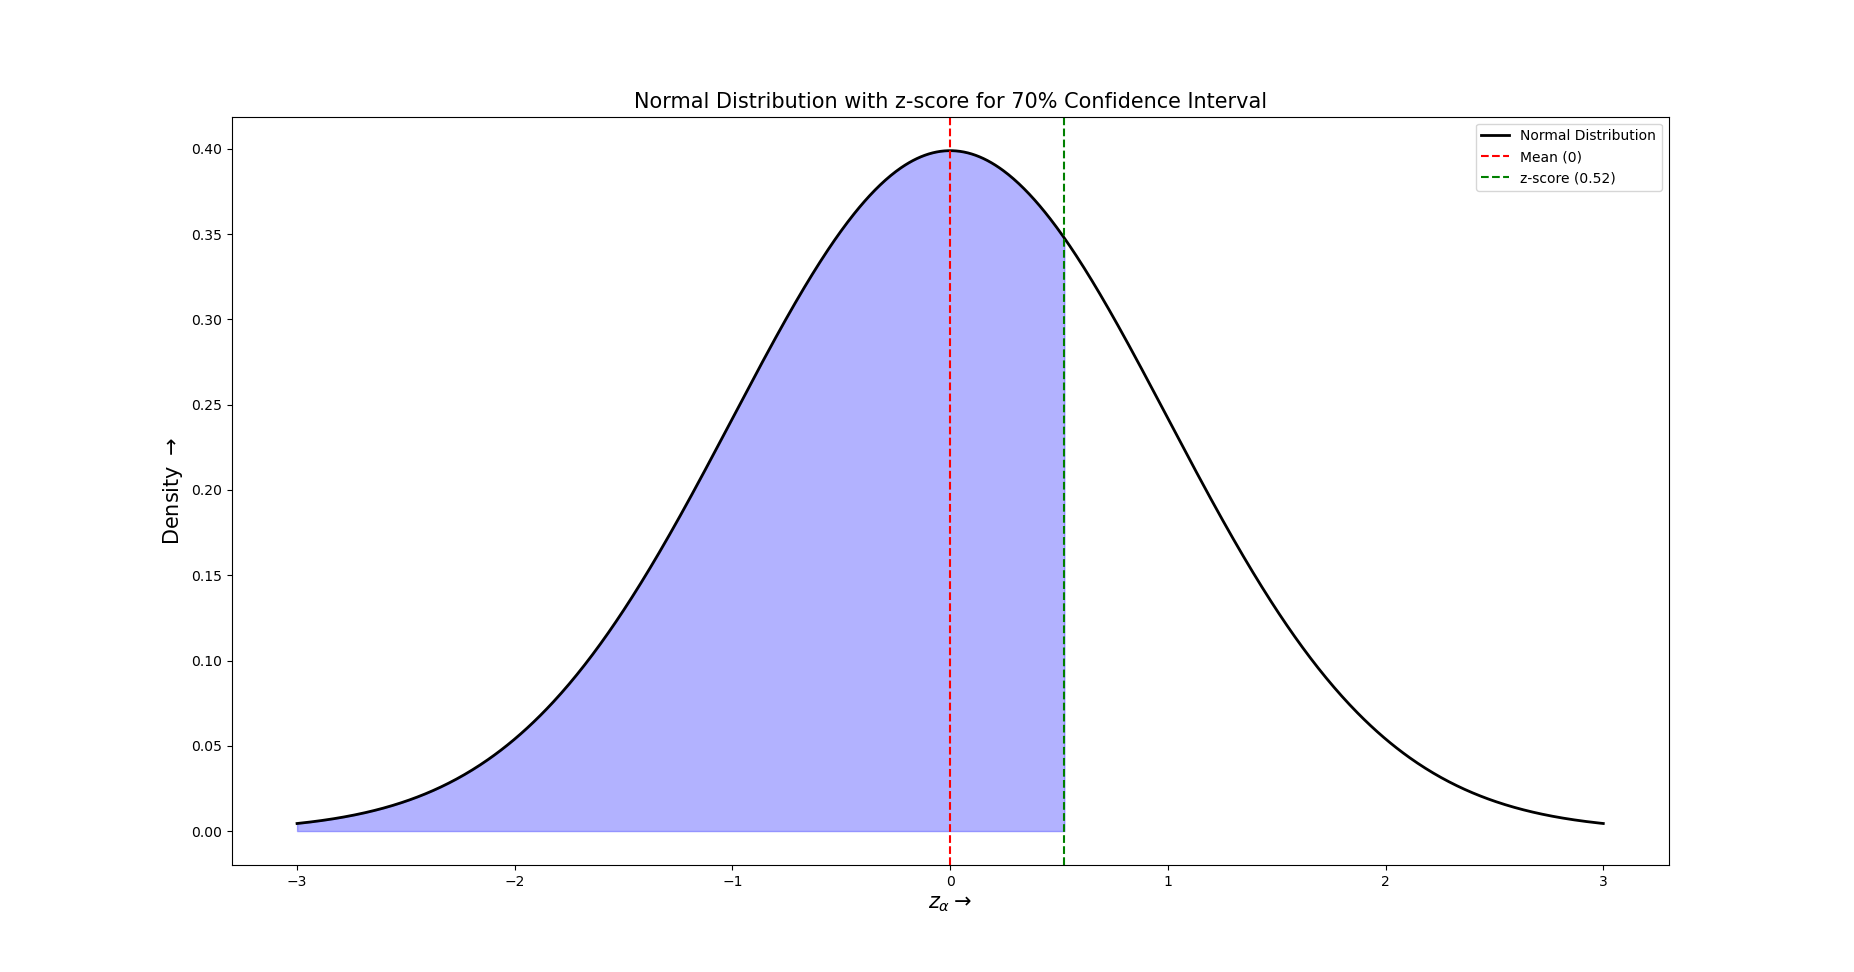

<h3>Student's t-distribution</h3>
The probability density function of the t-distribution is given by:
$$
f(x) = \frac{\Gamma(0.5(\nu + 1))}{\Gamma(0.5\nu) \sqrt{\pi \nu \beta}} \left[1 + \frac{(x-\mu)^2}{\nu \beta}\right]^{-0.5(1+\nu)}
$$
where $\nu$ is the key parameter, called the degree(s) of freedom. Its shape resembles that of a Gaussian, with a lower peak and fatter tails. In the limit $\nu \to \infty$, the t-distribution tends to the normal distribution. The Value at Risk for data obeying the t-distribution is given by<a href="#ref1"><sup>[1]</sup></a>
$$
\begin{equation}
\text{VaR}_t = \mu - t_{\alpha,\nu} \sqrt{\beta}
\end{equation}
$$
where $t_{\alpha,\nu}$ is similar to the z-score mentioned above:
$$
t_{\alpha,\nu} = \frac{x-\mu}{\sqrt{\beta}}
$$
If $\mu$ is the mean of the stock returns data and $\sigma$ its variance, we have:
$$
\beta = \sigma^2 \left (\frac{3 + \kappa}{3 + 2 \kappa} \right)
$$
where $\kappa=6/(\nu-4)$.

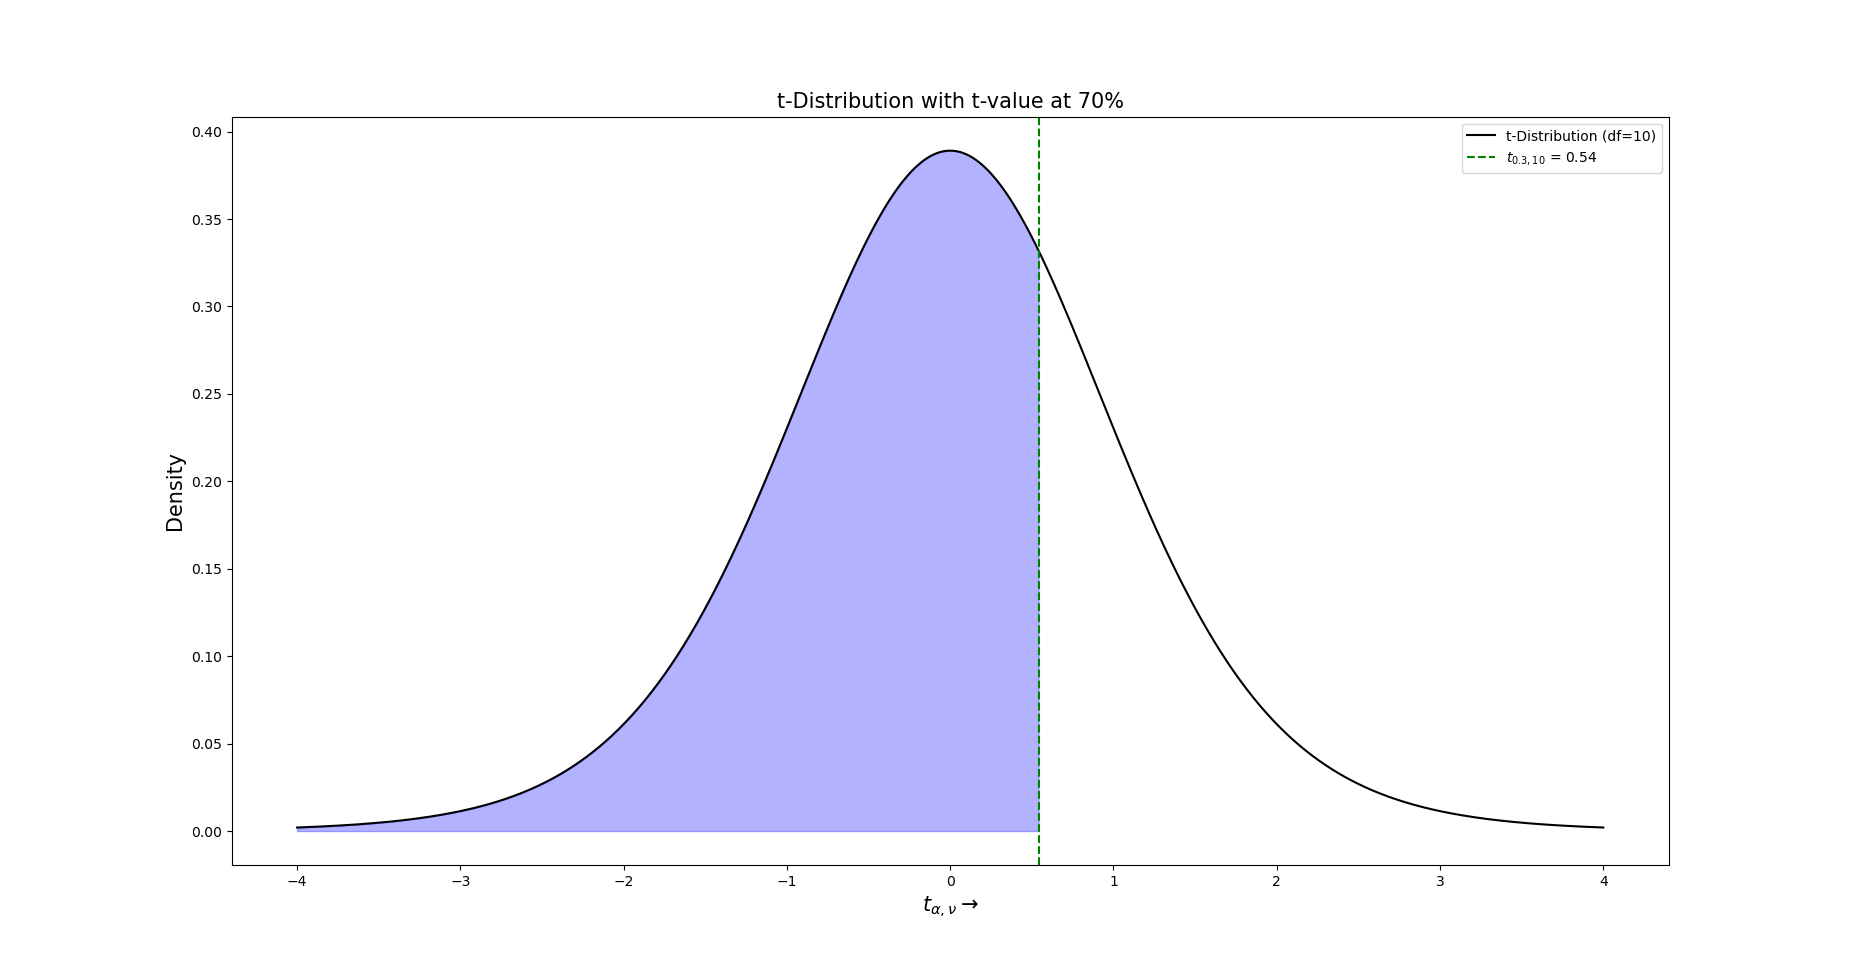

<h3>Monte Carlo simulations of Distributions</h3>

Although fitting the data to a distribution is a straightforward way to calculate the Value at Risk of historical returns, Monte Carlo simulations offer the possibility to model counterfactual outcomes with alternate parameters. For example, they enable predictions on risk for returns with slightly different means, or a mean that varies on a rolling basis. This notebook includes an elementary application of Monte Carlo methods: simulating stock returns distributed normally with a fixed mean and variance(matching that of the input data), and calculating the VaR for a large number of runs. Notebook #4 of this repository contains a more complex application with stochastic differential equations.

<h2 style="font-size:30px"><ins>CODE</ins></h2>
We begin by importing a few standard models that will be useful for the rest of this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import yfinance as yf
import pandas as pd

<h3> Normal Distribution</h3>
The following function calculates the VaR in Python using the normal distribution. The inputs are the data to be fitted, the confidence level to calculate the VaR at, and an x-axis to later visualize the fit against.

In [2]:
#Value-at-Risk using the normal dist.
def VaR_n(portfolio_returns, confidence_level,x):
    μ = np.mean(portfolio_returns)
    σ = np.std(portfolio_returns)
    z_α = stats.norm.ppf(confidence_level)  #z-score
    VaR_n = μ - z_α * σ
    print(f"\nVaR-n = {100*VaR_n:.4f}%")
    fit_n= stats.norm.pdf(x, μ, σ)
    #collect results
    results = VaR_n,fit_n
    return results

<h3> Student's t-Distribution</h3>
Similarly, the following function calculates the VaR in Python using Student's t-distribution. The inputs are the same as before.

In [3]:
#Value-at-Risk using the Student-t dist.
def VaR_t(portfolio_returns, confidence_level,x):
    σ = np.std(portfolio_returns)
    nu, loc_t, scale_t = stats.t.fit(portfolio_returns)    #fit data to t-dist.
    κ = stats.kurtosis(portfolio_returns, fisher=True)     #excess kurtosis 
    β = np.sqrt((3 + κ) / (3 + 2*κ))                       #beta(spread)
    t_α_nu = stats.t.ppf( confidence_level, df=nu)         #t-percentile score
    VaR_t = -t_α_nu* σ* β
    print(f"\nVaR-t = {100*VaR_t:.4f}%")
    fit_t = stats.t.pdf(x, nu, loc=loc_t, scale=scale_t)
    #collect results
    results = VaR_t,fit_t
    return results


<h3>Mone Carlo with Normal Distribution</h3>
Finally, the function below simulates stock returns under the assumption of normality and returns the Value at Risk for a set of simulations.

In [4]:
#Value-at-Risk using Monte Carlo simulations
def VaR_MC(portfolio_returns,n_runs,confidence_level,x):
    μ = np.mean(portfolio_returns)
    σ = np.std(portfolio_returns)
    n_days = len(portfolio_returns)
    simulated_returns = np.random.normal(μ, σ, (n_runs,n_days))
    VaR_mc = np.percentile(simulated_returns, 100*(1 - confidence_level))
    print(f"\nVaR-Monte Carlo = {100*VaR_mc:.4f}%")
    fit_mc = stats.norm.pdf(x,np.mean(simulated_returns),np.std(simulated_returns))
    #collect results
    results = VaR_mc,fit_mc
    return results

The main function below collects historical daily returns for a few tickers using $\texttt{yfinance}$ and implements all three methods to calculate the Value at Risk for a portfolio of stocks. Before executing it, we will first define two other functions to visualize the results.

In [5]:
def plot_all_returns(returns):
    plt.figure(figsize=(10, 6))
    for clmn in returns.columns:
        sns.histplot(returns[clmn], bins=50, alpha=0.5, label=clmn)
    plt.title("Individual Stock Returns")
    plt.xlabel("Returns(%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def plot_portfolio_returns(portfolio_returns,VaR,fits,x):
    VaR_n,VaR_t,VaR_mc = VaR
    fit_n,fit_t,fit_mc = fits
    fig, ax = plt.subplots(figsize=(10, 6))    
    #histogram of portfolio returns
    sns.histplot(portfolio_returns, bins=50, color="black", alpha=0.6, label="Portfolio Returns")
    ax.plot(x, fit_n, 'r-', label="Normal Fit")
    ax.plot(x, fit_t, 'b-', label="Student Fit")
    ax.plot(x, fit_mc, 'g-', label="MC Normal Fit")
    #show VaR
    ax.axvline(VaR_n, color='red', linestyle='dashed', linewidth=2, label=f'VaR_n ({VaR_n:.3f})')
    ax.axvline(VaR_t, color='blue', linestyle='dashed', linewidth=2, label=f'VaR_t ({VaR_t:.3f})')
    ax.axvline(VaR_mc, color='green', linestyle='dashed', linewidth=2, label=f'VaR_mc ({VaR_mc:.3f})')

    ax.set_title("Portfolio Returns with Fit and VaR")
    ax.set_xlabel("ln(Returns)")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.show()

The main function below puts everything together

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed



VaR-n = -2.4187%

VaR-t = -2.7101%

VaR-Monte Carlo = -2.4154%


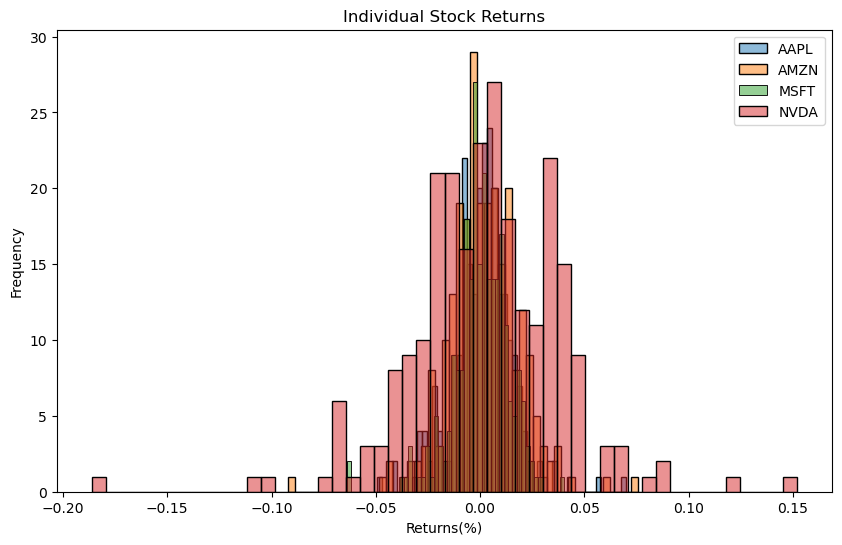

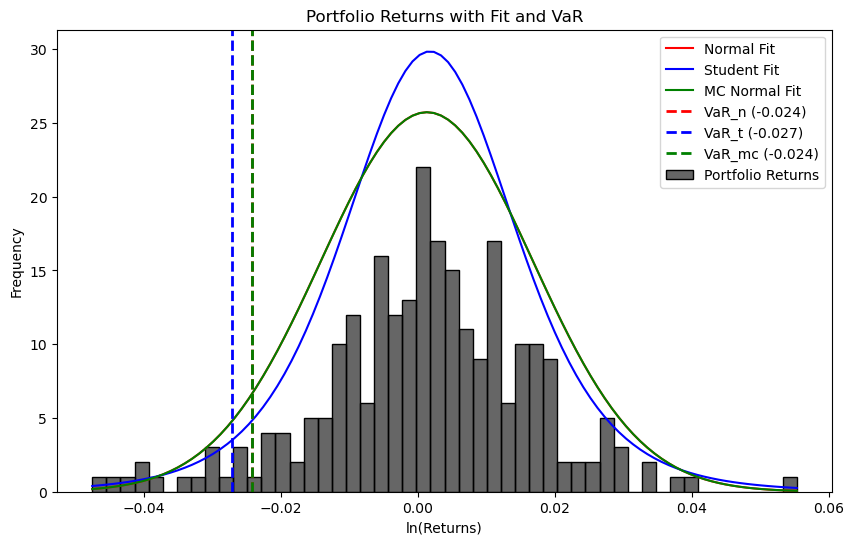

In [6]:
if __name__=="__main__":
    
    tickers = ["AMZN","MSFT","AAPL","NVDA"]    #choose portfolio of stocks
    confidence_level=0.95                      #set confidence level for VaR
    
    start =pd.Timestamp(2024,2,1)
    stop = pd.Timestamp(2025,2,1)
    
    data = yf.download(tickers, start, stop)   #download data
    weights = np.array([1/len(tickers) for i in range(len(tickers))])
    
    close_prices = data["Close"]
    logreturns = np.log(close_prices / close_prices.shift(1)).dropna()
    portfolio_returns = np.dot(logreturns,weights)
    
    x = np.linspace(min(portfolio_returns), max(portfolio_returns), 100)
    n_runs = 10000                             #num. of runs for Monte-Carlo function 
    
    var_n,fit_n= VaR_n(portfolio_returns,confidence_level,x)
    var_t,fit_t= VaR_t(portfolio_returns,confidence_level,x)
    var_mc,fit_mc = VaR_MC(portfolio_returns,n_runs,confidence_level,x)
    VaR = [var_n,var_t,var_mc]
    fits = (fit_n,fit_t,fit_mc)
    
    plot_all_returns(logreturns)
    plot_portfolio_returns(portfolio_returns,VaR,fits,x)    

## References
<a id="ref1"></a>[1] Chu‐Hsiung Lin, Shan‐Shan Shen "<a href="https://www.emerald.com/insight/content/doi/10.1108/15265940610664960/full/html?skipTracking=true">*Can the student‐t distribution provide accurate value at risk?*</a>".  Journal of Risk Finance, ISSN: 1526-5943.